In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from multiprocessing import Pool

SENSITIVITIES = [1, 2, 5, 10, 20]
FILE_NAMES = ["power-law", "bartels15", "log-normal", "ploeg", "gautam", "nptf", "bartels18"]
DISPLAY_NAMES = ["Wavelet 1", "Wavelet 2", "GLC", "GCE", "AIC", "NPTF", "Disk"]
SENS_TYPE = "smoothing"
if SENS_TYPE == "smoothing":
    N_REALS = [
        [10, 31, 49, 5, 3, 25, 10],# 1
        [27, 81, 101, 21, 12, 110, 29],# 2
        [87, 221, 210, 104, 57, 399, 121],# 5
        [194, 410, 317, 307, 169, 659, 342],# 10
        [401, 697, 425, 787, 453, 831, 881],# 20
    ]
else:
    N_REALS = [
        [31, 98, 124, 20, 12, 111, 30], # 1
        [77, 210, 220, 73, 41, 460, 89], # 2
        [230, 490, 380, 340, 180, 810, 370], # 5
        [470, 830, 490, 930, 520, 907, 1032], # 10
        [955, 1300, 570, 2200, 1400, 940, 2500], # 20
    ]

plt.style.use("jcap")

In [9]:
loadeds = {}

#The text in the file are pdfs calculated at the exact flux values written in the files. The cds are probably inaccurate.

def load_file(filename):
    global loadeds
    if filename in loadeds:
        return loadeds[filename]
    fluxes = []
    pdfs = []
    cdfs = []
    cdf = 0
    f = open(filename)
    for i, line in enumerate(f.readlines()):
        if line == "": continue
        flux, pdf, _ = line.split()
        fluxes.append(float(flux))
        pdfs.append(float(pdf))

    integral = 0
    for i in range(len(fluxes[:-1])):
        cdfs.append(integral)
        integral += pdfs[i] * (fluxes[i+1] - fluxes[i])
    cdfs.append(integral)
    pdfs = np.array(pdfs) / integral
    cdfs = 1 - np.array(cdfs) / integral
    
    loadeds[filename] = (np.asarray(fluxes), pdfs, cdfs)
    return np.asarray(fluxes), pdfs, cdfs

def draw_fluxes(ndraw, fluxes, cdfs):
    draws = np.zeros(ndraw)
    for i in range(ndraw):
        r = random.random()
        draws[i] = np.interp(r, cdfs, fluxes)
    return draws
    
    
def get_log_likelihood(sensitivity, data, hyp_func):
    hyp_fluxes, hyp_pdfs, _ = load_file("gen-cdfs/data-{}x/{}-{}.dat".format(sensitivity, FILE_NAMES[hyp_func], SENS_TYPE))
    log_like = 0
    for flux in data:
        log_like += np.log(np.interp(flux, hyp_fluxes, hyp_pdfs))
    return log_like

def get_ratio_matrix(sensitivity, ndraws, ntrials):
    mat = []
    for i in range(len(FILE_NAMES)): # True
        line = []
        
        real_fluxes, _, real_cdfs = load_file("gen-cdfs/data-{}x/{}-{}.dat".format(sensitivity,
                                               FILE_NAMES[i], SENS_TYPE))
        drawn_fluxes = draw_fluxes(ndraws[i] * ntrials, np.flip(real_fluxes), np.flip(real_cdfs))
        
        for j in range(len(FILE_NAMES)): # Hypothetical
            hyp_ll = get_log_likelihood(sensitivity, drawn_fluxes, j)
            true_ll = get_log_likelihood(sensitivity, drawn_fluxes, i)
            line.append(2 * (true_ll - hyp_ll) / ntrials)
        mat.append(np.asarray(line))
    return np.asarray(mat)

1x
Generated


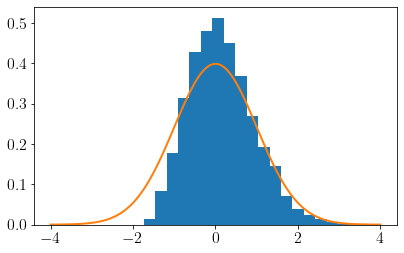

In [10]:
REAL = 0
FAKE = 1
SENSITIVITY = 0
N_TRIALS = 10000
print(f"{SENSITIVITIES[SENSITIVITY]}x")
real_fluxes, real_pdfs, real_cdfs = load_file("gen-cdfs/data-{}x/{}-{}.dat".format(SENSITIVITIES[SENSITIVITY],
                                               FILE_NAMES[REAL], SENS_TYPE))
drawn_fluxes = draw_fluxes(N_REALS[SENSITIVITY][REAL] * N_TRIALS, np.flip(real_fluxes),\
                           np.flip(real_cdfs)).reshape(N_TRIALS, N_REALS[SENSITIVITY][REAL])

print("Generated")

plt.figure()
tss = []

for i in range(N_TRIALS):
    true_ll = get_log_likelihood(SENSITIVITIES[SENSITIVITY], drawn_fluxes[i], REAL)
    hyp_ll = get_log_likelihood(SENSITIVITIES[SENSITIVITY], drawn_fluxes[i], FAKE)
    tss.append(2 * (true_ll - hyp_ll))
plt.hist(tss, bins=20, density=True)
gauss_x = np.linspace(-4, 4, 100)
plt.plot(gauss_x, np.exp(-gauss_x**2/2)/np.sqrt(2 * np.pi))

In [11]:
N_TRIALS = 10

def call_matrix_47(sens):
    return get_ratio_matrix(sens, [47]*len(FILE_NAMES), N_TRIALS) 
def call_matrix_scale(sens):
    return get_ratio_matrix(sens[1], N_REALS[sens[0]], N_TRIALS) 

#with Pool() as pool:
    #mats_47 = pool.map(call_matrix_47, SENSITIVITIES)
#    mats_scale = pool.map(call_matrix_scale, enumerate(SENSITIVITIES))
mats_scale = [call_matrix_scale(e)for e in enumerate(SENSITIVITIES)]
    
#print(np.array(mats_47).shape)
print(np.array(mats_scale).shape)
    
#np.savetxt("mats-47-{}.txt".format(SENS_TYPE), np.array(mats_47).flatten())
np.savetxt("short-mats-scale-{}.txt".format(SENS_TYPE), np.array(mats_scale).flatten())

(5, 7, 7)


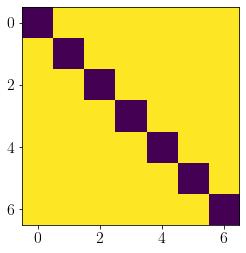

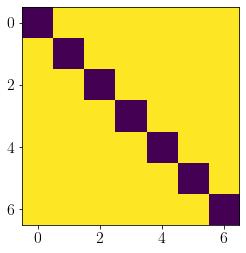

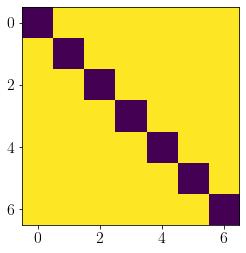

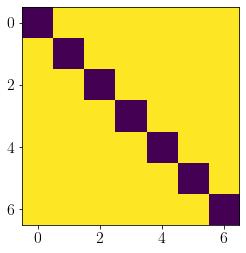

In [12]:
shape = (len(SENSITIVITIES), len(DISPLAY_NAMES), len(DISPLAY_NAMES))

#mats_47 = np.loadtxt("mats-47-{}.txt".format(SENS_TYPE)).reshape(shape)
mats_scale = np.loadtxt("mats-scale-{}.txt".format(SENS_TYPE)).reshape(shape)

for i in range(1, 5):
    plt.figure()
    plt.imshow(mats_scale[i]> mats_scale[i-1])

def display_flat(mats, cmap, suffix):
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12, 15))

    for i, mat in enumerate(mats):
        ax = axs[i//2, i%2]
        ax.xaxis.tick_top()
        c = ax.imshow(mat, vmin=0, vmax=20, cmap=cmap)
        if i % 2 == 0:
            ax.set_yticklabels(DISPLAY_NAMES)
        else:
            ax.set_yticklabels([""]*len(DISPLAY_NAMES))
        if i // 2 == 0:
            ax.set_xticklabels(DISPLAY_NAMES, rotation=90)
        else:
            ax.set_xticklabels([""]*len(DISPLAY_NAMES), rotation=90)
        ax.set_xticks(range(len(DISPLAY_NAMES)))
        ax.set_yticks(range(len(DISPLAY_NAMES)))
        for mi in range(len(DISPLAY_NAMES)):
            for mj in range(len(DISPLAY_NAMES)):
                color='k'
                if np.isnan(mat[mi, mj]):
                    continue
                if mat[mi, mj] > 13:
                    color='w'
                show_text = '%s' % float('%.2g' % mat[mi, mj])
                if mat[mi, mj] >= 10:
                    show_text = int(mat[mi, mj])
                if mat[mi, mj] < 0.1:
                    show_text = "$\sim$0"
                if abs(mat[mi, mj]) < 0.05:
                    show_text = "0.0"
                text = ax.text(mj, mi, show_text, ha="center", va="center", color=color, size=16)
        ax.set_title("Sensitivity $\\times$ {}".format(SENSITIVITIES[i]), y=-0.14)

    #cbar_ax = fig.add_axes([0.93, 0.03, 0.03, 0.8])
    #fig.colorbar(c, cax=cbar_ax, label="$\chi^2_r$")
    fig.delaxes(axs[2][1])

    fig.tight_layout()
    fig.savefig("unbinned-comparison-{}-sigma-{}.pdf".format(SENS_TYPE, suffix))

<ipython-input-12-25b3266d232e>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(DISPLAY_NAMES)
<ipython-input-12-25b3266d232e>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(DISPLAY_NAMES, rotation=90)
<ipython-input-12-25b3266d232e>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]*len(DISPLAY_NAMES))
<ipython-input-12-25b3266d232e>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]*len(DISPLAY_NAMES), rotation=90)


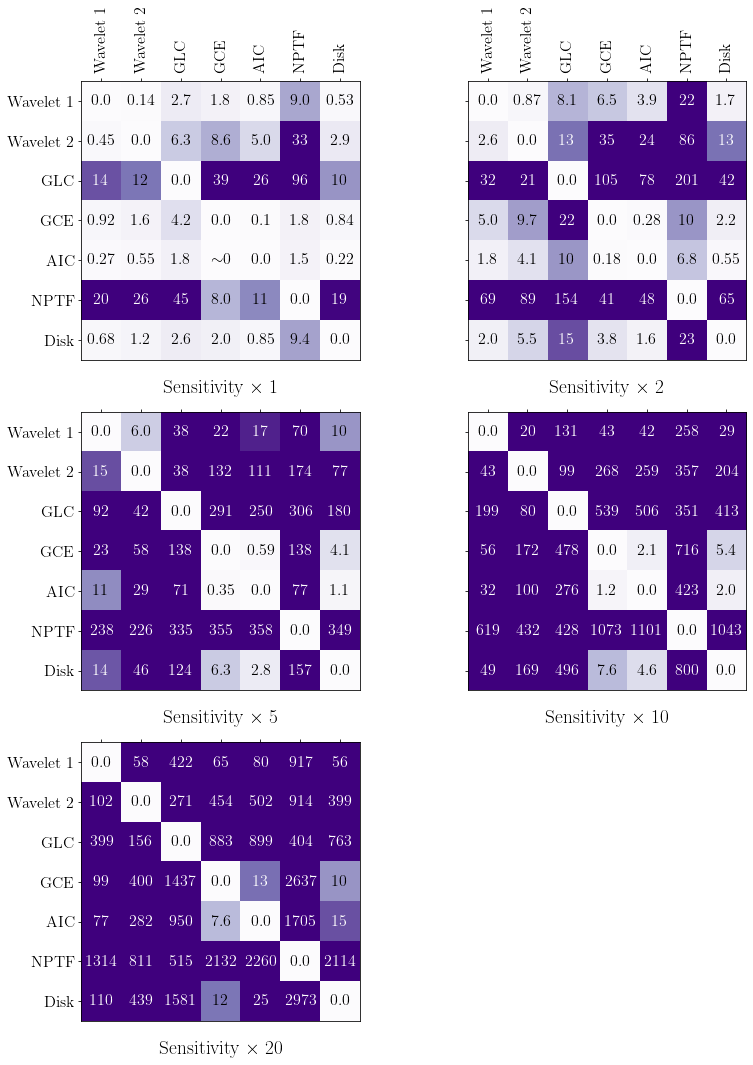

In [13]:
#display_flat(mats_47, "Reds", "47")
display_flat(mats_scale, "Purples", "scale")

# Compare both

<ipython-input-14-02e4df2c49d8>:6: RuntimeWarning: invalid value encountered in true_divide
  display_flat(np.abs(mats_pos / mats_smooth), "Reds", "ratio")
<ipython-input-12-25b3266d232e>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(DISPLAY_NAMES)
<ipython-input-12-25b3266d232e>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(DISPLAY_NAMES, rotation=90)
<ipython-input-12-25b3266d232e>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]*len(DISPLAY_NAMES))
<ipython-input-12-25b3266d232e>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]*len(DISPLAY_NAMES), rotation=90)


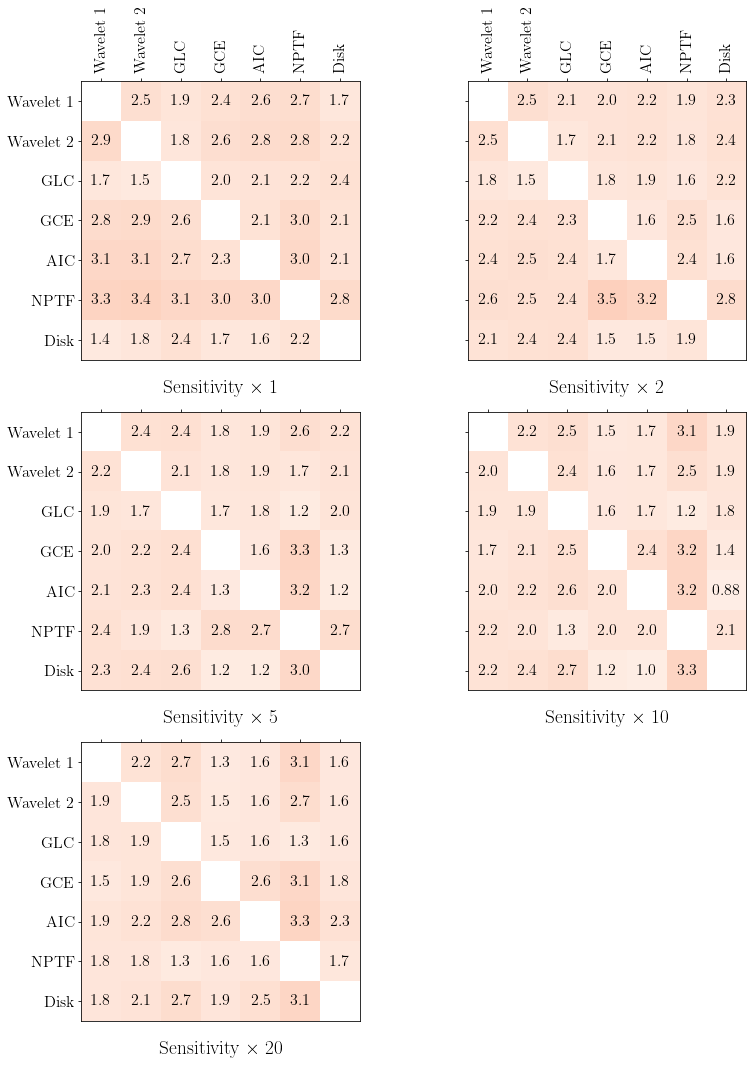

In [14]:
shape = (len(SENSITIVITIES), len(DISPLAY_NAMES), len(DISPLAY_NAMES))

mats_pos = np.loadtxt("mats-scale-position.txt").reshape(shape)
mats_smooth = np.loadtxt("mats-scale-smoothing.txt").reshape(shape)

display_flat(np.abs(mats_pos / mats_smooth), "Reds", "ratio")

## Display PDFs to check for errors

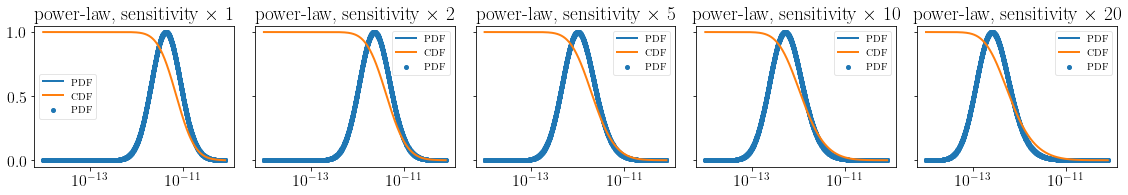

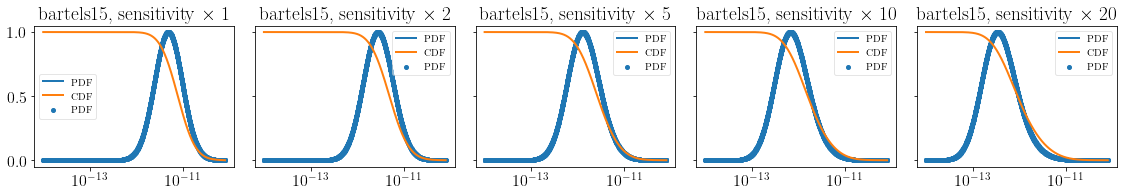

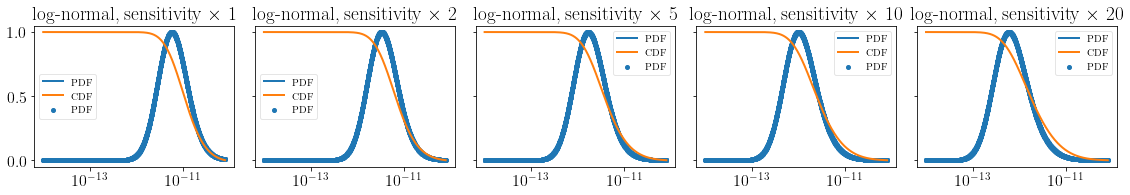

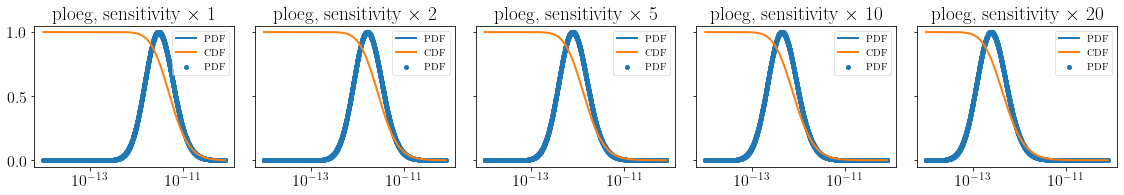

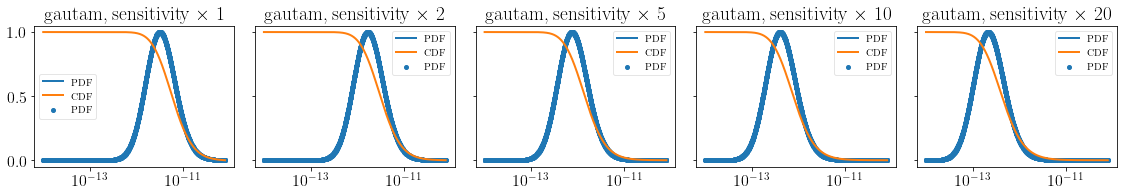

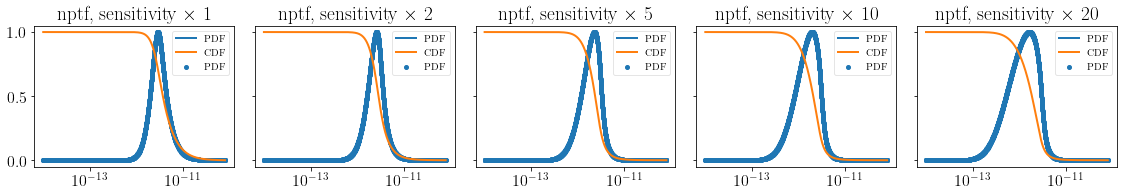

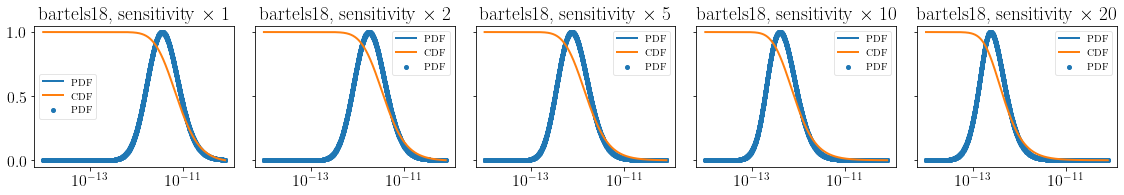

In [15]:
def plot_pdf(index):
    fig, axs = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(16, 3))
    for i, sens in enumerate(SENSITIVITIES):
        fluxes, pdfs, cdfs = load_file("gen-cdfs/data-{}x/{}-{}.dat".format(sens, FILE_NAMES[index], SENS_TYPE))
        axs[i].plot(fluxes, pdfs / np.max(pdfs), label='PDF')
        axs[i].scatter(fluxes, pdfs / np.max(pdfs), label='PDF')
        axs[i].set_title("{}, sensitivity $\\times$ {}".format(FILE_NAMES[index], sens))
        axs[i].plot(fluxes, cdfs, label='CDF')
        axs[i].set_xscale('log')
        axs[i].legend()
    fig.tight_layout()

for i in range(len(FILE_NAMES)):
    plot_pdf(i)

Done